In [1]:
import pandas as pd

import numpy as np
import scipy as sp

from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
import gensim
import sklearn

In [42]:
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY =  os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)
model_llm = genai.GenerativeModel("gemini-1.5-flash")
# model = genai.GenerativeModel(f"tunedModels/medquadmedicalqnadatasetfiltered-8p4omv4")

In [4]:
df_medquad = pd.read_csv("MedQuad-MedicalQnADataset.csv")
df_medquad.head()

,Unnamed: 0,qtype,Question,Answer
0,0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [73]:
df_pubmed_train = pd.read_csv("PubMed_200k_RCT/train.csv")
df_pubmed_test = pd.read_csv("PubMed_200k_RCT/test.csv")
df_pubmed = pd.concat([df_pubmed_train, df_pubmed_test], ignore_index=True)
df_pubmed.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24491034,24491034_0_11,The emergence of HIV as a chronic condition me...,0,11,BACKGROUND
1,24491034,24491034_1_11,This paper describes the design and evaluation...,1,11,BACKGROUND
2,24491034,24491034_2_11,This study is designed as a randomised control...,2,11,METHODS
3,24491034,24491034_3_11,The intervention group will participate in the...,3,11,METHODS
4,24491034,24491034_4_11,The program is based on self-efficacy theory a...,4,11,METHODS


# Preprocessing

In [77]:
df_pubmed = df_pubmed.dropna(subset=['abstract_text'])  # Remove rows with NaN in abstract_text
df_pubmed = df_pubmed.sort_values(by=['line_id'])
df_pubmed = df_pubmed.groupby('abstract_id').agg({'abstract_text':' '.join}).reset_index()
df_pubmed.head()

,abstract_id,abstract_text
0,1279170,We conducted this study to assess the clinical...
1,1281030,To determine whether prophylactic treatment wi...
2,1282364,After the discovery of type C hepatitis virus ...
3,1283117,Since it is not clear whether testosterone or ...
4,1283730,The aim was to study the pharmacokinetic param...


In [5]:
# add qa id to medquad
df_medquad['qa_id'] = range(1, len(df_medquad) + 1)
df_medquad = df_medquad[['qa_id', 'Question', 'Answer', 'qtype']]
df_medquad.head()

,qa_id,Question,Answer,qtype
0,1,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...,susceptibility
1,2,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,symptoms
2,3,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,susceptibility
3,4,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos...",exams and tests
4,5,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...",treatment


In [6]:
train_medquad, test_medquad = train_test_split(df_medquad, test_size=0.2, random_state=42)

# Word Embedding

## Biobert

In [43]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load BioBERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def get_biobert_embedding(text):
    """
    Get BioBERT embedding for a text
    
    Args:
        text (str): Input text
    Returns:
        numpy.ndarray: Embedding vector
    """
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt", max_length=512, 
                      truncation=True, padding=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Use [CLS] token embedding or mean of all tokens
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    
    return embeddings

# Replace the Word2Vec functions
def get_sentence_vector(sentence):
    """
    Get embedding vector for a sentence using BioBERT
    """
    return get_biobert_embedding(sentence)

In [8]:
from tqdm.notebook import tqdm
import pandas as pd

def process_embeddings(df):
    """
    Process embeddings for all texts in dataframe with progress bar
    """
    print("Generating embeddings...")
    
    # Process abstract texts
    abstract_vectors = []
    for text in tqdm(df['abstract_text'], desc="Processing abstracts"):
        abstract_vectors.append(get_biobert_embedding(text))
    df['abstract_vector'] = abstract_vectors
    
    # Process questions if they exist
    if 'Question' in df.columns:
        question_vectors = []
        for text in tqdm(df['Question'], desc="Processing questions"):
            question_vectors.append(get_biobert_embedding(text))
        df['question_vector'] = question_vectors
    
    return df

### Load Pubmed Embeddings

In [14]:
import pandas as pd
import numpy as np

def load_and_convert_embeddings(file_num):
    """
    Load embeddings from CSV file and convert string vectors back to numpy arrays
    """
    df = pd.read_csv(f'processed_embeddings/processed_embeddings_{file_num}.csv')
    # Convert string representation of vectors back to numpy arrays
    df['abstract_vector'] = df['abstract_vector'].apply(
        lambda x: np.array([float(i) for i in x.split(',')])
    )
    return df

def combine_all_embeddings():
    """
    Load and combine all processed embeddings files (1-8)
    """
    # Load first file
    combined_df = load_and_convert_embeddings(1)
    
    # Load and concatenate remaining files
    for i in range(2, 9):
        try:
            df = load_and_convert_embeddings(i)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
            print(f"Loaded and combined embeddings_{i}")
        except FileNotFoundError:
            print(f"Warning: processed_embeddings_{i}.csv not found")
    
    return combined_df

# Load and combine all embeddings
pubmed_embeddings = combine_all_embeddings()

print(f"Total number of embeddings: {len(pubmed_embeddings)}")
print(f"Shape of first embedding vector: {pubmed_embeddings['abstract_vector'].iloc[0].shape}")
print("Type of first embedding vector:", type(pubmed_embeddings['abstract_vector'].iloc[0]))

Loaded and combined embeddings_2
Loaded and combined embeddings_3
Loaded and combined embeddings_4
Loaded and combined embeddings_5
Loaded and combined embeddings_6
Loaded and combined embeddings_7
Loaded and combined embeddings_8
Total number of embeddings: 193154
Shape of first embedding vector: (768,)
Type of first embedding vector: <class 'numpy.ndarray'>


In [15]:
pubmed_embeddings.head()

,abstract_id,abstract_text,abstract_vector
0,1279170,We conducted this study to assess the clinical...,"[0.20418921, -0.132595, -0.008210841, 0.223240..."
1,1281030,To determine whether prophylactic treatment wi...,"[0.09223461, 0.1407401, -0.118942745, 0.220687..."
2,1282364,After the discovery of type C hepatitis virus ...,"[-0.012069235, -0.00780928, -0.086226486, 0.13..."
3,1283117,Since it is not clear whether testosterone or ...,"[0.017863387, -0.052003592, 0.007513125, 0.200..."
4,1283730,The aim was to study the pharmacokinetic param...,"[0.08064803, -0.15704384, -0.106707975, 0.2038..."


### Load Medquad Embeddings

In [18]:
def extract_vector(vector_str):
    # Remove brackets and split by spaces
    vector_str = vector_str.strip('[]')
    # Convert to numpy array of floats
    return np.array([float(x) for x in vector_str.split()])

medquad_embeddings = pd.read_csv(f'processed_embeddings/train_medquad.csv')
medquad_embeddings['question_vector'] = medquad_embeddings['question_vector'].apply(extract_vector)

print(f"Total number of embeddings: {len(medquad_embeddings)}")
print(f"Shape of first embedding vector: {medquad_embeddings['question_vector'].iloc[0].shape}")
print("Type of first embedding vector:", type(medquad_embeddings['question_vector'].iloc[0]))

Total number of embeddings: 13125
Shape of first embedding vector: (768,)
Type of first embedding vector: <class 'numpy.ndarray'>


# Information Retrieval

In [22]:
def find_top_k_abstracts(df, query_vector, abstract_vectors_col, k=3):
    cosine_scores = cosine_similarity([query_vector], np.array(df[abstract_vectors_col]).tolist())[0]
    top_k_indices = np.argsort(cosine_scores)[-k:][::-1]
    return df.iloc[top_k_indices]['abstract_id'].values, cosine_scores[top_k_indices]

def find_top_k_answers(df, query_vector, question_vectors_col, k=3):
    cosine_scores = cosine_similarity([query_vector], np.array(df[question_vectors_col]).tolist())[0]
    top_k_indices = np.argsort(cosine_scores)[-k:][::-1]
    return df.iloc[top_k_indices]['qa_id'].values, cosine_scores[top_k_indices]

def get_qa_pairs(df, qa_ids):
    return df[df['qa_id'].isin(qa_ids)][['qa_id', 'Question', 'Answer']]

def get_abstracts(df, abstract_ids):
    return df[df['abstract_id'].isin(abstract_ids)][['abstract_id', 'abstract_text']]

def query_top_k_answers_and_abstracts(df_1, df_2, query, k=10):
    query_vector = get_sentence_vector(query)

    qa_ids, question_scores = find_top_k_answers(df_1, query_vector, 'question_vector', k)
    abstract_ids, abstract_scores = find_top_k_abstracts(df_2, query_vector, 'abstract_vector', k)

    answers_df = get_qa_pairs(df_1, qa_ids)
    abstracts_df = get_abstracts(df_2, abstract_ids)

    answers_df['Similarity Score'] = question_scores
    abstracts_df['Similarity Score'] = abstract_scores

    return answers_df, abstracts_df

In [23]:
queries = [
    "What is the incubation period of COVID-19?",
    "Cure for fever?",
    "Who is at risk for Lymphocytic Choriomeningit",
    "What are the symptoms of Ligma?"
]

In [24]:
for query in queries:
    print(f"Query: {query}")
    answers_df, abstracts_df = query_top_k_answers_and_abstracts(medquad_embeddings, pubmed_embeddings, query)
    print("Top Answers:")
    display(answers_df)
    print("Top Abstracts:")
    display(abstracts_df)
    print("\n")

Query: What is the incubation period of COVID-19?
Top Answers:


,qa_id,Question,Answer,Similarity Score
658,14465,What are the symptoms of Fucosidosis type 1 ?,What are the signs and symptoms of Fucosidosis...,0.911123
711,12893,What are the symptoms of Cronkhite-Canada dise...,What are the signs and symptoms of Cronkhite-C...,0.910592
888,115,Who is at risk for Nocardiosis? ?,People with very weak immune (body defense) sy...,0.910592
1929,11019,What is (are) Zika virus infection ?,Zika virus infection is spread to people prima...,0.909483
2831,11020,What are the treatments for Zika virus infecti...,How might a Zika virus infection be treated? T...,0.909286
5733,157,Who is at risk for Hendra Virus Disease (HeV)? ?,Transmission of Hendra virus to humans can occ...,0.907044
5844,5270,What is (are) Zika Virus ?,Zika is a virus that is spread by mosquitoes. ...,0.906939
8197,153,what is the history of hps for Hantavirus ?,"The ""First""Outbreak\n \nIn May 1993, an outbr...",0.905759
10660,159,Who is at risk for Hendra Virus Disease (HeV)? ?,Australia’s “Flying fox” bats (genus Pteropus)...,0.904658
11985,12892,What is (are) Cronkhite-Canada disease ?,Cronkhite-Canada syndrome is a rare gastrointe...,0.904617


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
10006,8835550,To compare 2 treatment strategies in a prospec...,0.874937
71413,16406170,This study examined the transmissibility betwe...,0.872559
78299,16968235,Reactivation of herpes simplex virus-1 ( HSV-1...,0.871950
79234,17046320,Few studies have performed sequential evaluati...,0.871193
104649,19149900,Our aim was to determine the efficacy of a tri...,0.870045
149460,22591597,Foot-and-mouth disease ( FMD ) is the most eco...,0.869670
156045,23078120,To determined the pathogen-specific incidence ...,0.867720
161636,23437548,live attenuated oral Vibrio cholerae Ol El Tor...,0.867589
171325,24073254,Respiratory infections caused by adenovirus ( ...,0.867504
179342,24656175,During clinical development of the licensed Ja...,0.866922




Query: Cure for fever?
Top Answers:


,qa_id,Question,Answer,Similarity Score
1478,15905,What causes Arts syndrome ?,What causes Arts syndrome? Arts syndrome is ca...,0.887999
1814,13118,What causes Turner syndrome ?,What causes Turner syndrome? Turner syndrome i...,0.876425
2727,1822,What to do for Wilson Disease ?,- Wilson disease is a genetic disease that pre...,0.876197
3098,13009,What causes Norum disease ?,What causes Norum disease? Norum disease is ca...,0.875491
5037,14321,What causes Down syndrome ?,What causes Down syndrome? There are 3 possibl...,0.875141
6917,11708,What causes Gardner syndrome ?,What causes Gardner syndrome? Gardner syndrome...,0.874432
8466,3765,What causes Shingles ?,Shingles is caused by a virus called the varic...,0.874432
9026,1820,What to do for Wilson Disease ?,People with Wilson disease should reduce their...,0.874358
9331,156,How to prevent Q Fever ?,"In the United States, Q fever outbreaks have r...",0.873510
11814,225,How to prevent ?,Vaccines and Preventable Diseases On this Page...,0.872933


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
3101,7706104,To determine if a dextrose-saline solution man...,0.760058
9119,8709689,Conventional advice on immediate treatment of ...,0.751508
12713,9166032,To examine if sucrose has an analgesic effect ...,0.750478
17681,9679365,To describe the use of an N-of-1 randomised cl...,0.749255
36737,11709746,For the therapy of preeclamptic patients is Ur...,0.748337
60016,15531624,Low response rates to surveys are a problem in...,0.748309
65386,15939222,To examine whether telling symptomatic patient...,0.748274
90873,17971948,Clinical diagnosis will clear any part of the ...,0.748238
108424,19420956,Homeopathy uses information gathered from heal...,0.748047
115288,19942104,In Germany autologous blood therapy ( ABT ) is...,0.747481




Query: Who is at risk for Lymphocytic Choriomeningit
Top Answers:


,qa_id,Question,Answer,Similarity Score
286,2584,Who is at risk for Neuroblastoma? ?,The risk factors for neuroblastoma are not known.,0.969961
2542,3266,Who is at risk for Childhood Astrocytomas? ?,Anything that increases your risk of getting a...,0.956168
2795,3182,Who is at risk for Hairy Cell Leukemia? ?,Gender and age may affect the risk of hairy ce...,0.944765
6120,3085,Who is at risk for Primary CNS Lymphoma? ?,Having a weakened immune system may increase t...,0.941623
7429,3136,Who is at risk for Chronic Lymphocytic Leukemi...,Older age can affect the risk of developing ch...,0.935771
7698,3,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,0.930914
7936,1630,Who is at risk for Microscopic Colitis: Collag...,No. Unlike the other inflammatory bowel diseas...,0.925619
10759,2,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,0.924923
11842,6,How to prevent Lymphocytic Choriomeningitis (L...,LCMV infection can be prevented by avoiding co...,0.924718
12568,5,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...",0.922905


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
3032,7692755,Six children who had mature or immature sacroc...,0.859236
5632,8150787,To examine thyroid indices in a community refe...,0.851146
42935,12365884,To describe and to determine the robustness of...,0.851062
61290,15636257,To evaluate bacterial flora of conjunctival sa...,0.850067
65478,15945499,Specific immunotherapy ( SIT ) in children bei...,0.849189
79176,17040577,To evaluate the levels of circulating immune c...,0.848791
105668,19219569,Tuberculous meningitis ( TBM ) is a fairly com...,0.847491
119648,20363036,To appreciate the several head and neck manife...,0.847141
163064,23531053,Tumor of the follicular infundibulum ( TFI ) i...,0.846914
165828,23707162,Attenuated Listeria monocytogenes vaccine stra...,0.846775




Query: What are the symptoms of Ligma?
Top Answers:


,qa_id,Question,Answer,Similarity Score
1588,15793,What are the symptoms of Tucker syndrome ?,What are the signs and symptoms of Tucker synd...,0.970509
2327,12428,What are the symptoms of C syndrome ?,What are the signs and symptoms of C syndrome?...,0.968633
2738,15212,What are the symptoms of Aniridia ?,What are the signs and symptoms of Aniridia? T...,0.967809
3722,14816,What are the symptoms of Reynolds syndrome ?,What are the signs and symptoms of Reynolds sy...,0.965991
4053,12924,What are the symptoms of Young syndrome ?,What are the signs and symptoms of Young syndr...,0.965253
6209,14996,What are the symptoms of Fountain syndrome ?,What are the signs and symptoms of Fountain sy...,0.965004
6596,15226,What are the symptoms of Miller syndrome ?,What are the signs and symptoms of Miller synd...,0.964801
6897,12855,What are the symptoms of N syndrome ?,What are the signs and symptoms of N syndrome?...,0.964360
11311,12386,What are the symptoms of Ainhum ?,What are the signs and symptoms of Ainhum? The...,0.964298
11406,15904,What are the symptoms of Arts syndrome ?,What are the signs and symptoms of Arts syndro...,0.964258


Top Abstracts:


,abstract_id,abstract_text,Similarity Score
410,1468285,To prove the efficacy of mexiletine in painful...,0.840091
18132,9717924,A problem acupuncture research has to face is ...,0.838928
20149,9926051,This paper sets out the rationale for the PRiS...,0.835558
42809,12355350,Idiopathic glossodynia is generally considered...,0.834339
65478,15945499,Specific immunotherapy ( SIT ) in children bei...,0.834270
100017,18709590,Gender differences in reported family cancer h...,0.833722
110329,19567768,Uterovaginal agenesis ( Mayer-Rokitansky-Kster...,0.833406
113657,19819095,This randomly controlled experiment tested a t...,0.833196
135727,21654609,The premenstrual dysphoric disorder ( PMDD ) i...,0.832999
188234,25389218,A recently published study showed the safety a...,0.832651


# Pass Context to LLM

In [37]:
GEMINI_API_KEY =  os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")
# model = genai.GenerativeModel(f"tunedModels/medquadmedicalqnadatasetfiltered-8p4omv4")

In [54]:
# def call_llm(context, query):
#     prompt = f"Answer the following medical question based on the provided context."

#     prompt += f"\nQuestion: {query}\n"

#     prompt += "\nRelevant Medical QA Pairs::\n"
#     for i, qa in enumerate(context['answers'], 1):
#         prompt += f"\nQA Pair {i}:\nQ: {qa['Question']}\nA: {qa['Answer']}\n"
    
#     prompt += "\nRelevant Medical Research Abstracts:\n"
#     for i, abstract in enumerate(context['abstracts'], 1):
#         prompt += f"\nAbstract {i}:\n{abstract['abstract_text']}\n"
    
#     prompt += "\nBased on the above context, do not make up an answer and do not use your existing knowledge, please provide a comprehensive answer to the question."

#     response = model.generate_content(prompt)
    
#     return response 

In [44]:
# Changed Prompt
def call_llm(context, query):
    prompt = f"You are a medical expert assistant. Answer the following medical question comprehensively and accurately. If the provided context contains relevant information, use it. If not, use your general medical knowledge to provide the best possible answer."

    prompt += f"\nQuestion: {query}\n"

    prompt += "\nContext:\n"
    prompt += "\nRelevant Medical QA Pairs:\n"
    for i, qa in enumerate(context['answers'], 1):
        prompt += f"\nQA Pair {i}:\nQ: {qa['Question']}\nA: {qa['Answer']}\n"
    
    prompt += "\nRelevant Medical Research Abstracts:\n"
    for i, abstract in enumerate(context['abstracts'], 1):
        prompt += f"\nAbstract {i}:\n{abstract['abstract_text']}\n"
    
    prompt += "\nProvide a clear, direct, and comprehensive answer to the question. Focus on being helpful and informative to the user."

    response = model_llm.generate_content(prompt)
    
    return response 

In [45]:
def process_medical_query(df_1, df_2, query):
    answers_df, abstracts_df = query_top_k_answers_and_abstracts(df_1, df_2, query)
    
    if len(answers_df) == 0 and len(abstracts_df) == 0:
        return {
            'response': "I apologize, but I don't have enough reliable information to answer this question.",
            'confidence': 'low'
        }
    
    context = {
        'answers': answers_df.to_dict(orient='records'),
        'abstracts': abstracts_df.to_dict(orient='records')
    }
    
    llm_response = call_llm(context, query)
    
    return {
        'response': llm_response.text,
        'confidence': 'high'
    }

test_query = "Who is at risk for Lymphocytic Choriomeningit?"
result = process_medical_query(medquad_embeddings, pubmed_embeddings, test_query)
print(result['response'])

Individuals of all ages are at risk of Lymphocytic Choriomeningitis (LCM) if they come into contact with the urine, feces, saliva, or blood of wild mice.  Pet mice or hamsters from contaminated colonies or those infected by wild mice also pose a risk to their owners.  Pregnant women can transmit the infection to their fetuses (vertical transmission), leading to serious consequences for the developing child.  Laboratory workers handling the virus or infected animals are also at risk, though this risk can be mitigated through appropriate safety precautions and sourcing of animals.



# Evaluation

# Test_Medquad

In [46]:
from nltk.translate.chrf_score import sentence_chrf
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import numpy as np
import pandas as pd

def calculate_rouge(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return {
        'ROUGE-1': scores['rouge1'].fmeasure,
        'ROUGE-L': scores['rougeL'].fmeasure
    }

def calculate_meteor(prediction, reference):
    pred_tokens = nltk.word_tokenize(prediction.lower())
    ref_tokens = nltk.word_tokenize(reference.lower())
    return meteor_score([ref_tokens], pred_tokens)

def calculate_chrf(prediction, reference):
    return sentence_chrf(reference, prediction, min_len=1, beta=2.0)

def calculate_metrics(predictions, references):
    individual_scores = []
    
    for pred, ref in zip(predictions, references):
        scores = {}
        
        # Calculate ROUGE scores
        rouge_scores = calculate_rouge(pred, ref)
        scores.update(rouge_scores)
        
        # Calculate METEOR score
        scores['METEOR'] = calculate_meteor(pred, ref)
        
        # Calculate chrF2 score
        scores['chrF2'] = calculate_chrf(pred, ref)
        
        individual_scores.append(scores)
    
    # Calculate average scores
    avg_scores = {
        metric: np.mean([s[metric] for s in individual_scores])
        for metric in individual_scores[0].keys()
    }
    
    return avg_scores, individual_scores

def evaluate_llm(test_df, medquad_embeddings, pubmed_embeddings, sample_size=10):
    # Sample random questions from test set
    test_sample = test_df.sample(n=sample_size, random_state=42)
    
    questions = test_sample['Question'].tolist()
    true_answers = test_sample['Answer'].tolist()
    
    # Get predictions
    predicted_answers = []
    for question in questions:
        result = process_medical_query(medquad_embeddings, pubmed_embeddings, question)
        predicted_answers.append(str(result['response']))
    
    # Calculate all metrics
    avg_metrics, individual_metrics = calculate_metrics(predicted_answers, true_answers)
    
    # Create evaluation dataframe
    eval_data = []
    
    for i, (question, true_ans, pred_ans, metrics) in enumerate(zip(
        questions, true_answers, predicted_answers, individual_metrics)):
        
        eval_data.append({
            'Question': question,
            'True Answer': true_ans,
            'Predicted Answer': pred_ans,
            'True Length': len(true_ans.split()),
            'Predicted Length': len(pred_ans.split()),
            'Length Ratio': len(pred_ans.split()) / len(true_ans.split()),
            **metrics  # Unpack all metrics
        })
    
    # Create DataFrame
    eval_df = pd.DataFrame(eval_data)
    
    # Print detailed results
    print("\nDetailed Evaluation Results:")
    print("\nMetrics Summary:")
    metrics_cols = ['ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']
    print(eval_df[metrics_cols].describe())
    
    print("\nLength Analysis:")
    print(f"Average True Answer Length: {eval_df['True Length'].mean():.1f} words")
    print(f"Average Predicted Answer Length: {eval_df['Predicted Length'].mean():.1f} words")
    print(f"Average Length Ratio: {eval_df['Length Ratio'].mean():.1f}x")
    
    return eval_df, avg_metrics

print("Starting evaluation...")
eval_df, avg_metrics = evaluate_llm(test_medquad, medquad_embeddings, pubmed_embeddings)

Starting evaluation...

Detailed Evaluation Results:

Metrics Summary:
         ROUGE-1    ROUGE-L     METEOR      chrF2
count  10.000000  10.000000  10.000000  10.000000
mean    0.343202   0.180771   0.264445   0.387416
std     0.086897   0.050665   0.057696   0.065531
min     0.190000   0.095000   0.201133   0.284253
25%     0.285586   0.147227   0.218649   0.344057
50%     0.352923   0.175427   0.248211   0.379554
75%     0.420607   0.214873   0.293449   0.437544
max     0.442736   0.256000   0.380875   0.494143

Length Analysis:
Average True Answer Length: 199.0 words
Average Predicted Answer Length: 268.1 words
Average Length Ratio: 2.0x


In [47]:
print("\nEvaluation DataFrame (first few rows):")
display(eval_df[['Question', 'True Answer', 'Predicted Answer', 'ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']].head())

print("\nAverage Metrics:")
for metric, score in avg_metrics.items():
    print(f"{metric}: {score:.4f}")


Evaluation DataFrame (first few rows):


,Question,True Answer,Predicted Answer,ROUGE-1,ROUGE-L,METEOR,chrF2
0,How to diagnose Peripheral Artery Disease ?,Peripheral artery disease (P.A.D.) is diagnose...,Diagnosing Peripheral Artery Disease (PAD) inv...,0.442736,0.219831,0.213160,0.379853
1,What is (are) Prostate Cancer ?,Surgery is a common treatment for early stage ...,Prostate cancer is a malignant disease where c...,0.190000,0.095000,0.246601,0.284253
2,What is (are) Drowning ?,People drown when they get too much water in t...,Drowning occurs when someone submerges in a li...,0.311321,0.160377,0.201133,0.340633
3,What is (are) Long QT syndrome 1 ?,Romano-Ward syndrome is the most common form o...,Long QT syndrome 1 (LQT1) is a specific type o...,0.277008,0.138504,0.324619,0.320922
4,What is (are) X-linked adrenal hypoplasia cong...,X-linked adrenal hypoplasia congenita is a dis...,X-linked adrenal hypoplasia congenita (AHC) is...,0.438298,0.200000,0.380875,0.494143



Average Metrics:
ROUGE-1: 0.3432
ROUGE-L: 0.1808
METEOR: 0.2644
chrF2: 0.3874


### With Normalization

In [48]:
from nltk.translate.chrf_score import sentence_chrf
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import numpy as np
import pandas as pd

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

def truncate_or_pad_text(text, target_length):
    words = text.split()
    if len(words) > target_length:
        # Truncate to target length
        return ' '.join(words[:target_length])
    return text

def calculate_rouge(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return {
        'ROUGE-1': scores['rouge1'].fmeasure,
        'ROUGE-L': scores['rougeL'].fmeasure
    }

def calculate_meteor(prediction, reference):
    pred_tokens = nltk.word_tokenize(prediction.lower())
    ref_tokens = nltk.word_tokenize(reference.lower())
    return meteor_score([ref_tokens], pred_tokens)

def calculate_chrf(prediction, reference):
    return sentence_chrf(reference, prediction, min_len=1, beta=2.0)

def calculate_metrics(predictions, references):
    individual_scores = []
    
    for pred, ref in zip(predictions, references):
        # Normalize texts to lowercase and remove extra whitespace
        pred = ' '.join(pred.lower().split())
        ref = ' '.join(ref.lower().split())
        
        # Calculate length ratio for normalization
        pred_len = len(pred.split())
        ref_len = len(ref.split())
        # Option 1: Use min(pred_len, ref_len) / max(pred_len, ref_len)
        ratio = min(pred_len, ref_len) / max(pred_len, ref_len) if pred_len > 0 else 1
        
        scores = {}
        
        # Calculate ROUGE scores and normalize
        rouge_scores = calculate_rouge(pred, ref)
        scores['ROUGE-1'] = rouge_scores['ROUGE-1'] * ratio
        scores['ROUGE-L'] = rouge_scores['ROUGE-L'] * ratio
        
        # Calculate and normalize METEOR score
        scores['METEOR'] = calculate_meteor(pred, ref) * ratio
        
        # Calculate and normalize chrF2 score
        scores['chrF2'] = calculate_chrf(pred, ref) * ratio
        
        individual_scores.append(scores)
    
    # Calculate average scores
    avg_scores = {
        metric: np.mean([s[metric] for s in individual_scores])
        for metric in individual_scores[0].keys()
    }
    
    return avg_scores, individual_scores

def evaluate_llm(test_df, medquad_embeddings, pubmed_embeddings, sample_size=10):
    # Sample random questions from test set
    test_sample = test_df.sample(n=sample_size, random_state=42)
    
    questions = test_sample['Question'].tolist()
    true_answers = test_sample['Answer'].tolist()
    
    # Get predictions
    predicted_answers = []
    for question in questions:
        result = process_medical_query(medquad_embeddings, pubmed_embeddings, question)
        predicted_answers.append(str(result['response']))
    
    # Calculate all metrics
    avg_metrics, individual_metrics = calculate_metrics(predicted_answers, true_answers)
    
    # Create evaluation dataframe
    eval_data = []
    
    for i, (question, true_ans, pred_ans, metrics) in enumerate(zip(
        questions, true_answers, predicted_answers, individual_metrics)):
        
        # Normalize texts
        true_ans_norm = normalize_text(true_ans)
        pred_ans_norm = truncate_or_pad_text(
            normalize_text(pred_ans), 
            len(true_ans_norm.split())
        )
        
        eval_data.append({
            'Question': question,
            'True Answer': true_ans,
            'Predicted Answer': pred_ans,
            'Normalized True Answer': true_ans_norm,
            'Normalized Predicted Answer': pred_ans_norm,
            'Original True Length': len(true_ans.split()),
            'Original Predicted Length': len(pred_ans.split()),
            'Normalized Length': len(true_ans_norm.split()),
            **metrics
        })
    
    # Create DataFrame
    eval_df = pd.DataFrame(eval_data)
    
    print("\nDetailed Evaluation Results:")
    print("\nMetrics Summary:")
    metrics_cols = ['ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']
    print(eval_df[metrics_cols].describe())
    
    print("\nLength Analysis:")
    print(f"Average Original True Length: {eval_df['Original True Length'].mean():.1f} words")
    print(f"Average Original Predicted Length: {eval_df['Original Predicted Length'].mean():.1f} words")
    print(f"Average Normalized Length: {eval_df['Normalized Length'].mean():.1f} words")
    
    return eval_df, avg_metrics

# Run evaluation
print("Starting evaluation...")
eval_df, avg_metrics = evaluate_llm(test_medquad, medquad_embeddings, pubmed_embeddings)


Starting evaluation...

Detailed Evaluation Results:

Metrics Summary:
         ROUGE-1    ROUGE-L     METEOR      chrF2
count  10.000000  10.000000  10.000000  10.000000
mean    0.200580   0.110017   0.143818   0.223628
std     0.100340   0.055313   0.063002   0.095577
min     0.031946   0.017654   0.042993   0.047932
25%     0.146901   0.082612   0.101489   0.175509
50%     0.192758   0.105165   0.148363   0.237351
75%     0.295220   0.146633   0.180293   0.298532
max     0.321811   0.196894   0.259839   0.353686

Length Analysis:
Average Original True Length: 199.0 words
Average Original Predicted Length: 267.8 words
Average Normalized Length: 199.0 words


In [49]:
print("\nEvaluation DataFrame (first few rows):")
display(eval_df[['Question', 'True Answer', 'Predicted Answer', 'ROUGE-1', 'ROUGE-L', 'METEOR', 'chrF2']].head())

print("\nAverage Metrics:")
for metric, score in avg_metrics.items():
    print(f"{metric}: {score:.4f}")


Evaluation DataFrame (first few rows):


,Question,True Answer,Predicted Answer,ROUGE-1,ROUGE-L,METEOR,chrF2
0,How to diagnose Peripheral Artery Disease ?,Peripheral artery disease (P.A.D.) is diagnose...,Diagnosing peripheral artery disease (PAD) inv...,0.302883,0.146649,0.147804,0.270730
1,What is (are) Prostate Cancer ?,Surgery is a common treatment for early stage ...,Prostate cancer is a malignant disease where c...,0.031946,0.017654,0.042993,0.047932
2,What is (are) Drowning ?,People drown when they get too much water in t...,Drowning is the process of experiencing respir...,0.081309,0.043782,0.075646,0.113918
3,What is (are) Long QT syndrome 1 ?,Romano-Ward syndrome is the most common form o...,Long QT syndrome (LQTS) type 1 is a genetic di...,0.144356,0.078365,0.148921,0.174498
4,What is (are) X-linked adrenal hypoplasia cong...,X-linked adrenal hypoplasia congenita is a dis...,X-linked adrenal hypoplasia congenita (AHC) is...,0.321811,0.164562,0.259839,0.353686



Average Metrics:
ROUGE-1: 0.2006
ROUGE-L: 0.1100
METEOR: 0.1438
chrF2: 0.2236


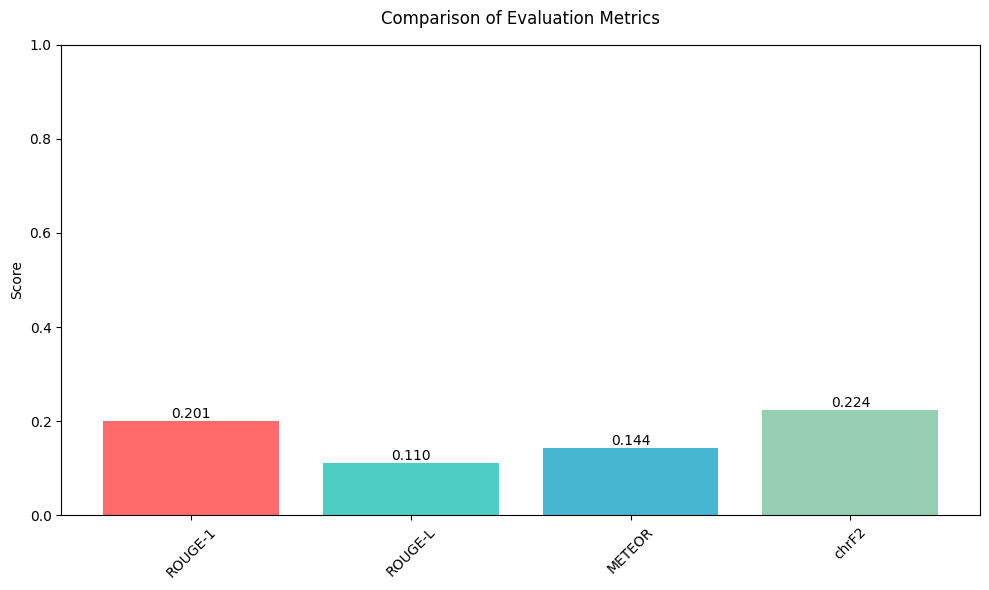

In [50]:
import matplotlib.pyplot as plt

# Extract metrics and scores
metrics = list(avg_metrics.keys())
scores = list(avg_metrics.values())

# Define colors for each metric
colors = {
    'ROUGE-1': '#FF6B6B',    # Coral red
    'ROUGE-L': '#4ECDC4',    # Turquoise
    'METEOR': '#45B7D1',     # Sky blue
    'chrF2': '#96CEB4'       # Sage green
}

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=[colors[metric] for metric in metrics])

# Customize the chart
plt.title('Comparison of Evaluation Metrics', fontsize=12, pad=15)
plt.ylabel('Score', fontsize=10)
plt.ylim(0, 1)  # Metrics typically range from 0 to 1

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()